<a href="https://colab.research.google.com/github/Pranav-Pedaballe/Emotion_classification/blob/main/emotion_classification_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from keras.utils import np_utils
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics
from keras.layers import Input
import zipfile
import os

In [1]:
with zipfile.ZipFile("Audio_Speech_Actors_01-24.zip", 'r') as zip_ref:
    zip_ref.extractall("Speech")
with zipfile.ZipFile("Audio_Song_Actors_01-24.zip", 'r') as zip_ref:
    zip_ref.extractall("Song")

In [2]:
def extract(file_path):
    parts=os.path.basename(file_path).split("-")
    modality="speech" if parts[1]=="01" else "song"
    emotion_code = int(parts[2])
    emotion_dict = {
        1: "neutral", 2: "calm", 3: "happy", 4: "sad",
        5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"
    }
    return modality, emotion_dict[emotion_code]

data = []

for root, _, files in os.walk("Speech"):
    for f in files:
        if f.endswith(".wav"):
            modality, emotion = extract(f)
            data.append({"file": os.path.join(root, f), "modality": modality, "emotion": emotion})

for root, _, files in os.walk("Song"):
    for f in files:
        if f.endswith(".wav"):
            modality, emotion = extract(f)
            data.append({"file": os.path.join(root, f), "modality": modality, "emotion": emotion})

df = pd.DataFrame(data)
df.to_csv("ravdess.csv", index=False)

In [3]:
!pip install librosa soundfile

In [5]:
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

In [6]:
def extract_feature(data, sr):

    stft = np.abs(librosa.stft(data))
    result = np.array([])
    mfccs=librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
    mfccs1 = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfccs1))
    delta1 = librosa.feature.delta(mfccs)
    delta2 = librosa.feature.delta(mfccs, order=2)
    delta1_mean = np.mean(delta1.T, axis=0)
    delta2_mean = np.mean(delta2.T, axis=0)
    result = np.hstack((result,delta1_mean, delta2_mean))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
    result = np.hstack((result, chroma))
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T,axis=0)
    result = np.hstack((result, mel))
    spec_centr=np.mean(librosa.feature.spectral_centroid(y=data, sr=sr).T, axis=0)
    spec_bw=np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sr).T, axis=0)
    #rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sr).T, axis=0)
    #flatness = np.mean(librosa.feature.spectral_flatness(y=data).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, spec_centr, spec_bw, zcr))
    #result = np.hstack((result,rolloff, flatness))
    rmse = np.mean(librosa.feature.rms(y=data).T, axis=0)
    #print("rmse shape:",rmse.shape)
    result = np.hstack((result, rmse))
    #tempo, _ = librosa.beat.beat_track(y=data, sr=sr)
    #print("tempo shape:",tempo.shape)
    #result = np.hstack((result, tempo))
    #y_harm, y_perc = librosa.effects.hpss(data)
    #harmonic_energy = np.mean(librosa.feature.rms(y=y_harm).T, axis=0)
    #percussive_energy = np.mean(librosa.feature.rms(y=y_perc).T, axis=0)
    #print("harm shape:",harmonic_energy.shape)
    #print("harm shape:",percussive_energy.shape)
    #result = np.hstack((result, harmonic_energy, percussive_energy))
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data), sr=sr).T, axis=0)
    #print("tonnetz shape:",tonnetz.shape)
    #result = np.hstack((result, tonnetz))
    #contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sr).T, axis=0)
    #print("contrast shape:",contrast.shape)
    #result = np.hstack((result, contrast))
    return result

In [7]:
def noise(data, noise_level=0.005):
    return data + noise_level * np.random.randn(len(data))

def shift(data, sr, shift_max=0.25):
    shift= int(sr * shift_max)
        return np.roll(data, shift_amt)

def load_data(save=False):
    x, y = [],[]
    for folder in ["Speech", "Song"]:
        for root, _, files in os.walk(folder):
            for file in files:
                if file.endswith(".wav"):
                    full_path = os.path.join(root, file)
                    try:
                        data, sr = librosa.load(full_path)

                        # Original
                        feature = extract_feature(data, sr)
                        x.append(feature)

                        # Label
                        emotion = extract_metadata_from_filename(file)[1]
                        y.append(emotion)


                    except Exception as e:
                        print(f"Error processing {full_path}: {e}")

    if save:
        np.save("X_augmented.npy", np.array(x))
        np.save("y_augmented.npy", np.array(y))

    return np.array(x), y


In [8]:
X, y = load_data(save=True)
print(f"Loaded {len(X)} samples.")

Loaded 2452 samples.


In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [45]:
X_aug = []
y_aug = []
to_augment = {"disgust", "fearful","neutral","surprised","happy","calm"}
for i in range(len(x_train)):
    label = y_train[i]
    if label not in to_augment:
        continue
    subset = df[df['emotion'] == label]
    if subset.empty:
        continue
    file_path = subset.sample(n=1)['file'].values[0]
    data, sr = librosa.load(file_path)
    n_data = noise(data)
    n_feature = extract_feature(n_data, sr)
    X_aug.append(n_feature)
    y_aug.append(label)
    s_data_r = shift(data, sr, 0.25)
    s_feature_r = extract_feature(s_data_r, sr)
    X_aug.append(s_feature_r)
    y_aug.append(label)

x_train = np.concatenate([x_train, np.array(X_aug)], axis=0)
y_train = np.concatenate([y_train, np.array(y_aug)], axis=0)

print(f"Training samples after augmenting: {len(x_train)}")

Training samples after augmenting 'disgust' and 'sad': 4703


In [46]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{np.str_('angry'): np.int64(0), np.str_('calm'): np.int64(1), np.str_('disgust'): np.int64(2), np.str_('fearful'): np.int64(3), np.str_('happy'): np.int64(4), np.str_('neutral'): np.int64(5), np.str_('sad'): np.int64(6), np.str_('surprised'): np.int64(7)}


In [47]:
model = Sequential()
model.add(Input(shape=(264, 1)))
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
)
model.add(Activation('softmax'))
opt = Adam(learning_rate=0.001)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [49]:
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)


#class_weights = compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history=model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test),batch_size=64,callbacks=[early_stop])

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 491ms/step - accuracy: 0.1580 - loss: 9.8291 - val_accuracy: 0.1752 - val_loss: 2.1502
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 481ms/step - accuracy: 0.2659 - loss: 1.9788 - val_accuracy: 0.3788 - val_loss: 1.8373
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 470ms/step - accuracy: 0.4145 - loss: 1.6805 - val_accuracy: 0.4236 - val_loss: 1.6587
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 487ms/step - accuracy: 0.4855 - loss: 1.5345 - val_accuracy: 0.4745 - val_loss: 1.6372
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 479ms/step - accuracy: 0.5396 - loss: 1.4211 - val_accuracy: 0.4949 - val_loss: 1.6204
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 472ms/step - accuracy: 0.5485 - loss: 1.4005 - val_accuracy: 0.5418 - val_loss: 1.4748
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 478ms/step - accuracy: 0.5842 - loss: 1.2985 - val_accuracy: 0.5703 - val_loss: 1.3440
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 469ms/step - accuracy: 0.6159 - loss: 1.2462 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
              precision    recall  f1-score   support

       angry       0.96      0.81      0.88        80
        calm       0.94      0.94      0.94        68
     disgust       0.85      0.83      0.84        48
     fearful       0.77      0.94      0.84        80
       happy       0.91      0.88      0.89        77
     neutral       0.79      0.84      0.82        32
         sad       0.88      0.80      0.84        82
   surprised       0.81      0.88      0.84        24

    accuracy                           0.87       491
   macro avg       0.86      0.87      0.86       491
weighted avg       0.87      0.87      0.87       491



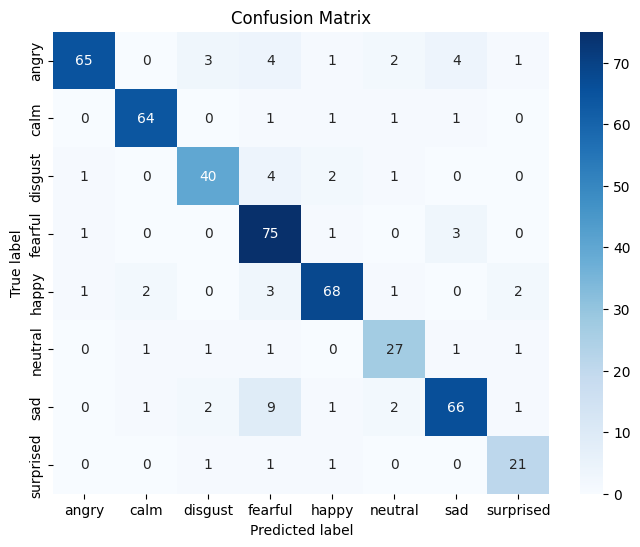

Accuracy for class 'angry': 81.25%
Accuracy for class 'calm': 94.12%
Accuracy for class 'disgust': 83.33%
Accuracy for class 'fearful': 93.75%
Accuracy for class 'happy': 88.31%
Accuracy for class 'neutral': 84.38%
Accuracy for class 'sad': 80.49%
Accuracy for class 'surprised': 87.50%


In [51]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predict class‐probabilities on the test set
y_pred_probs = model.predict(XTestProcessed)

# 2. Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Print the classification report
#print(classification_report(y_test, y_pred,target_names=list(le_name_mapping.keys())))
print(classification_report(y_test, y_pred, target_names=labelencoder.classes_))

# 4. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 5. (Optional) Visualize the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=labelencoder.classes_,
            yticklabels=labelencoder.classes_,
            cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

class_accuracy = cm.diagonal() / cm.sum(axis=1)
for label, acc in zip(labelencoder.classes_, class_accuracy):
    print(f"Accuracy for class '{label}': {acc:.2%}")